##  0.0. Objetivo do Problema:


-- 1.0. Previsao do primeiro destino que um novo usuário irá escolher.

-- Porque?
    -- Qual tipo de modelo de negócio do Airbnb? 
    
    
        - Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
        - Oferta ( pessoas oferecendo acomodacao )
            - Tamanho do portfólio.
            - Diversidade/Densidade de Portfólio.
            - Preco Medio

        - Demanda ( pessoas procurando acomodacao )
            - Numero de Usuários
            - LTV ( Lifetime Value )
            - CAC ( Client Acquisition Cost )


           Gross Revenue = ( Fee * Numero cliente ) - CAC 

##  0.1. Proposta de solução:


--- Modelo de Predizao do primeiro destino de um novo usario.

- 1.0. Predicoes e salva em tabela do banco de dados. 
- 2.0. API 
        --- Input: usuario e suas caracteristicas
        --- Output: usuario e suas caracteristicas com a **predicao do destino**

--- 16 ciclos

# <font color ='red'> 1.0. Imports </font> 

In [1]:
import random
import pandas                               as pd

from sklearn      import model_selection    as ms
from sklearn      import preprocessing      as pp
from sklearn      import metrics            as m

from scikitplot   import metrics            as mt

from keras        import models             as ml
from keras        import layers             as l

import warnings

warnings.filterwarnings("ignore")



2022-03-02 16:04:18.497490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 16:04:18.497529: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1.1. Helper Function

## 1.2. Loading Data

In [2]:
df_raw = pd.read_csv('~/repositorio/airbnb_predict/data/raw/train_users_2.csv', low_memory=True)
df_sessions = pd.read_csv('~/repositorio/airbnb_predict/data/raw/sessions.csv', low_memory=True)

# 2.0. Data Description


In [3]:
df2 = df_raw.copy()

In [4]:
print('Number of rows: {}'.format(df2.shape[0]))
print('Number of columns: {}'.format(df2.shape[1]))

Number of rows: 213451
Number of columns: 16


## 2.1. Data Type


In [5]:
df2.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 2.2. NA Check


In [6]:
df2.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [7]:
# remove missing value completly

df2 = df2.dropna()

## 2.3. Change Data Type


In [8]:
# 'date_account_created'
df2['date_account_created'] = pd.to_datetime(df2['date_account_created'])

# 'timestamp_first_active'
df2['timestamp_first_active'] = pd.to_datetime(df2['timestamp_first_active'], format = '%Y%m%d%H%M%S')

# 'date_first_booking'
df2['date_first_booking'] = pd.to_datetime(df2['date_first_booking'])

# 'age'
df2['age'] = df2['age'].astype('int64')


## 2.4. Check Balanced Data


In [9]:
df2['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 3.0.  Data Filtering


In [10]:
df3 = df2.copy()

## 3.1.  Filtering Rows


## 3.2.  Columns Selection

# 4.0.  Data Preparation


In [11]:
df4 = df3.copy()

In [12]:
# dummy variable
df4_dummy = pd.get_dummies(df4.drop(['id','country_destination'], axis =1))

# join id and country destination
df4 = pd.concat([df4[['id','country_destination']],df4_dummy], axis =1)

# 5.0. Feature Selection


In [13]:
df5 = df4.copy()

In [14]:
cols_drop = ['date_account_created','timestamp_first_active','date_first_booking'] # original dates

In [15]:
df5 = df5.drop(cols_drop, axis =1)

In [16]:
X = df5.drop(['id','country_destination'], axis = 1)
Y = df5['country_destination'].copy()

In [17]:
# Split dataset into training and test

X_train, X_test , y_train, y_test = ms.train_test_split(X, Y, test_size = 0.2 , random_state=32)

# 6.0. Machine Learning Model


In [18]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

## 6.1. Baseline Model


In [41]:
country_destination_list = df5['country_destination'].drop_duplicates().sort_values().to_list()
k_num = y_test.shape[0]
country_destination_weights = df5['country_destination'].value_counts(normalize= True).sort_index().to_list()

# modelo aleatorio
yhat_random = random.choices (population = country_destination_list , 
                              weights = country_destination_weights,
                              k = k_num )

13635

### 6.1.1 Performance


Accuracy: 0.5203520352035204
Balanced Accuracy: 0.09050693069435443
Kappa Score: -0.0030916197373529464


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

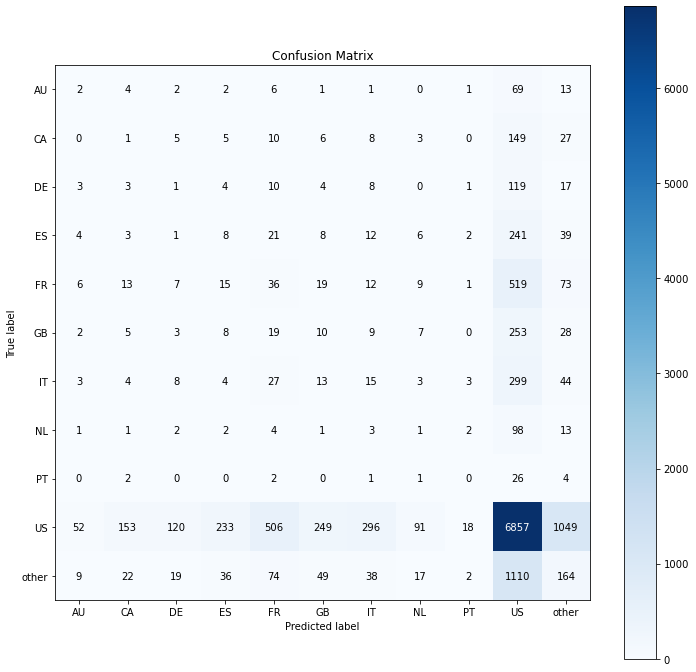

In [45]:
# accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_acc_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_acc_random))

# confusion matrix
mt.plot_confusion_matrix(y_test , yhat_random, normalize=False, figsize=(12,12))

## 6.2. Neural Network - MLP

In [19]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim = X_train.shape[1], activation= 'relu'))
model.add(l.Dense(11,  activation= 'softmax'))

# model compile
model.compile(loss = 'categorical_crossentropy' , optimizer='adam', metrics=['accuracy'])

# tain model
model.fit(X_train, y_train_nn, epochs=100)

Epoch 1/100


2022-03-02 16:04:25.485931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 16:04:25.486111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 16:04:25.486175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-02 16:04:25.486226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-02 16:04:25.486310: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

1705/1705 [==============================] - 2s 1ms/step - loss: 1.3679 - accuracy: 0.7005
Epoch 2/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2849 - accuracy: 0.7076
Epoch 3/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2487 - accuracy: 0.7076
Epoch 4/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2282 - accuracy: 0.7081
Epoch 5/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2028 - accuracy: 0.7082
Epoch 6/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1842 - accuracy: 0.7086
Epoch 7/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1715 - accuracy: 0.7087
Epoch 8/100
1705/1705 [==============================] - 2s 994us/step - loss: 1.1559 - accuracy: 0.7087
Epoch 9/100
1705/1705 [==============================] - 2s 986us/step - loss: 1.1454 - accuracy: 0.7087
Epoch 10/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1

1705/1705 [==============================] - 2s 996us/step - loss: 1.0993 - accuracy: 0.7120
Epoch 80/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0987 - accuracy: 0.7119
Epoch 81/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0997 - accuracy: 0.7118
Epoch 82/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0982 - accuracy: 0.7115
Epoch 83/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0988 - accuracy: 0.7118
Epoch 84/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0977 - accuracy: 0.7120
Epoch 85/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0982 - accuracy: 0.7121
Epoch 86/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0977 - accuracy: 0.7119
Epoch 87/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0976 - accuracy: 0.7117
Epoch 88/100
1705/1705 [==============================] - 2s 1ms/step - los

### 6.2.1 NN Performance


In [20]:
# prediction
pred_nn = model.predict(X_test)

# invert Predict
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

Accuracy: 0.7037770443711038
Balanced Accuracy: 0.09158602356022304
Kappa Score: 0.0013964045438905615


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

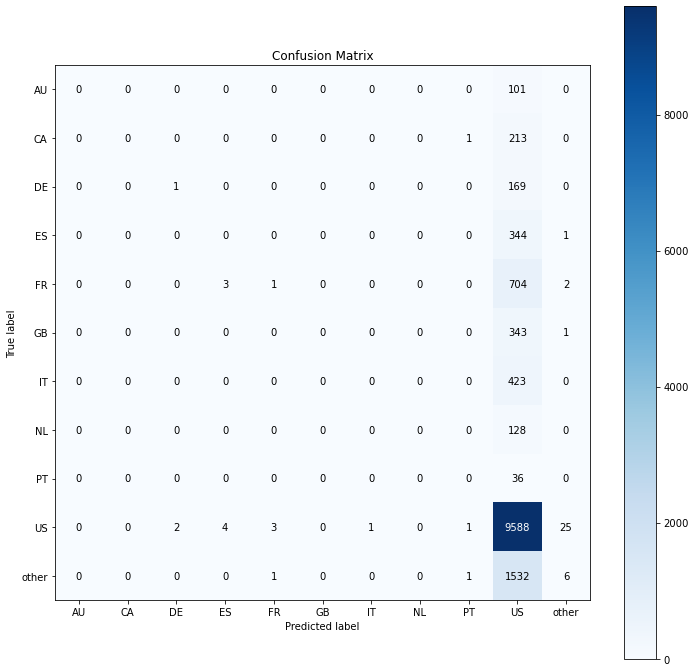

In [23]:
# accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_acc_nn))

# confusion matrix
mt.plot_confusion_matrix(y_test_nn , yhat_nn, normalize=False, figsize=(12,12))

### 6.2.2 NN Performance - Cross Validation


In [ ]:
# gerate k-fold

num_fold = 5
kfold = ms.StratifiedKFold ( n_splits = num_folds , shuffle = True, random_state = 32 )

balanced_acc_list = []
kappa_acc_nn_list = []

i = 1
for train_ix , val_ix in kfold.split (X_train, y_train):
    print(' Fold Number : {}/{}'.format(i, num_fold))
    # get fold
    x_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoging
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()
     
    # model definition
    model = ml.Sequential()
    model.add(l.Dense(256 , input_dim =X_train.shape[1] , activation = 'relu' ))
    model.add(l.Dense(11 , activation = 'softmax' ))

    # compile model
    model.compile ( loss = 'categorical_crossentropy', optimizer = 'adam' , metrics=['accuracy'])

    # training model
    model.fit( x_train_fold , y_train_fold_nn, epochs = 100, batch_size = 32, verbose = 0)
    
    # prediction
    pred_nn = model.predict(x_val_fold)

    # invert Predict
    yhat_nn = ohe.inverse_transform(pred_nn)

    #  prepare data
    y_test_nn = x_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1,-1)[0]    
    
    # metrics
    # Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    # Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_nn_list.append(kappa_acc_nn)

    i +=  1

 Fold Number : 1/5


In [ ]:
print ("Avg Balanced Acurracy : {} +/- {}".format(np.mean(balanced_acc_list), np.std(balanced_acc_list))
print ("Avg Kappa Score : {} +/- {}".format(np.mean(kappa_acc_nn_list), np.std(kappa_acc_nn_list))